# School Matcher Graph

This notebook explores creating a LangGraph for the SchoolMatch AI project.

## 1. Setup and Imports


In [1]:
# Import necessary libraries

import enum
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, Graph
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict

from langchain_app.merger_analyzer import (
    create_merger_feature_extractor,
    create_compatibility_analyzer,
    create_merger_recommendation_formatter,
    create_final_recommender
)
from langchain_app.school_matcher_graph import create_school_matcher_graph, run_school_matcher
from db.college_vector_store import CollegeVectorStore

In [2]:
## langsmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "schoolmatch-ai"

In [3]:
# Initialize the vector store
vector_store = CollegeVectorStore()

# Create the graph
graph = create_school_matcher_graph(vector_store)

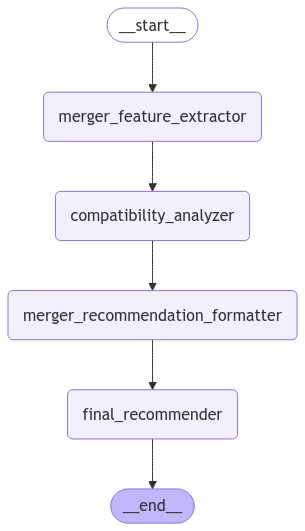

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
# Run the graph with Seattle University
result = run_school_matcher(graph, "Seattle University")

# Print all analyses first
for analysis in result["compatibility_analyses"]:
    print(f"\nPartner: {analysis['partner']}")
    print(analysis["analysis"])

# Print the final recommendation
print("\nFinal Recommendation:")
print(result["final_recommendation"])


Partner: University of Washington
1. Score: 75/100

2. Key Synergies:
   - Location: Both institutions are located in Seattle, which could facilitate collaboration and sharing of resources.
   - Academic Programs: Both universities offer a wide range of undergraduate, graduate, and professional degree programs. There could be potential for collaboration or cross-registration in areas of shared strength, such as Business, Law, and Nursing.
   - Values: Both institutions have a strong commitment to social justice, diversity, and community engagement, which could form the basis for joint initiatives or programs.

3. Challenges:
   - Size and Scope: The University of Washington is a much larger institution, with over 45,000 students. This could lead to challenges in aligning processes and resources.
   - Type: Seattle University is a private, Jesuit institution, while the University of Washington is a public university. This could lead to differences in governance, funding, and mission.
 

In [3]:
class NodeName(enum.Enum):
    START = START
    END = END
    MERGER_FEATURE_EXTRACTOR = "merger_feature_extractor"
    COMPATIBILITY_ANALYZER = "compatibility_analyzer"
    MERGER_RECOMMENDATION_FORMATTER = "merger_recommendation_formatter"


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
vector_store = CollegeVectorStore()

graph_builder = StateGraph(State)

## 2. Define the Graph

Outline the nodes and edges for your LangGraph.


In [6]:
# Create nodes
merger_feature_extractor = create_merger_feature_extractor(llm)
# compatibility_analyzer = create_compatibility_analyzer(vector_store, llm)
# merger_recommendation_formatter = create_merger_recommendation_formatter(llm)

# Add nodes to graph
graph_builder.add_node(NodeName.MERGER_FEATURE_EXTRACTOR.value, merger_feature_extractor)
# graph_builder.add_node(NodeName.COMPATIBILITY_ANALYZER.value, compatibility_analyzer)
# graph_builder.add_node(NodeName.MERGER_RECOMMENDATION_FORMATTER.value, merger_recommendation_formatter)

# Define edges
graph_builder.add_edge(NodeName.START.value, NodeName.MERGER_FEATURE_EXTRACTOR.value)
# graph_builder.add_edge(NodeName.MERGER_FEATURE_EXTRACTOR.value, NodeName.COMPATIBILITY_ANALYZER.value)
# graph_builder.add_edge(NodeName.COMPATIBILITY_ANALYZER.value, NodeName.MERGER_RECOMMENDATION_FORMATTER.value)
# graph_builder.add_edge(NodeName.MERGER_RECOMMENDATION_FORMATTER.value, NodeName.END.value)
graph_builder.add_edge(NodeName.MERGER_FEATURE_EXTRACTOR.value, END)

# Compile graph
workflow = graph_builder.compile()

### Visualize the Graph

In [7]:
graph = graph_builder.compile()

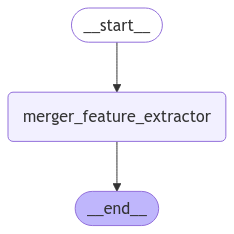

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass